# A basic training loop

We will progressively work through several different ways to run a training loop on a basic neural net on the MNIST data set.  We will begin with a version that is primarily in pure Python, and then incrementally add more PyTorch functionality.  Using PyTorch modules and methods will make our code more readable, flexible, and easier to use.  The goal of this notebook is to illustrate the usefulness of PyTorch, and how to use it when training a neural net.

Please note, we will import modules and methods directly before we use them (even though this is not the standard way of writing production code) since we want to make it clear **when** we are using various modules, and what the minimal amount of code needed is at each point.

## MNIST data setup

In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from pathlib import Path

DATA_PATH = Path('../data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

We download the MNIST dataset, a classic dataset consisting of black-and-white images hand-drawn digits (between 0 and 9).

In [4]:


URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

In [ ]:
import requests
if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

Although our dataset consists of images, they have been stored using pickle, a python-specific format for compressing data sets.

In [5]:
import pickle, gzip,torch

with gzip.open(str(PATH/FILENAME), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

It is always a good idea to take a look at your data to make sure it is what you expect it to be.  Here, our training set consists of 50,000 images.  Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28)

In [6]:
x_train.shape

(50000, 784)

We can use matplotlib and numpy to display the first image in our training set:

In [11]:
from matplotlib import pyplot
import numpy as np

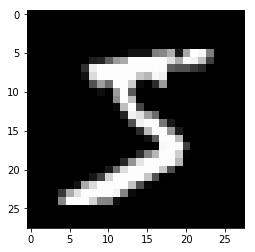

In [12]:
pyplot.imshow(np.reshape(x_train[0], (28,28)), cmap="gray")

Now we will import PyTorch.  We will be storing our data as *tensors*.  You can think of a *tensor* as a multidimensional matrix.  The PyTorch data type tensor is also capable of storing what actions were performed on the data (which is information we will need to calculate gradients later on!)

# What is new in pytorch .4?

### Convert to tensor: torch.tensor(obj)

In [7]:
import torch 

In [8]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [9]:
type(x_train) # should not be used to check type
x_train.type()

torch.Tensor

'torch.FloatTensor'

### requires_grad

In [10]:
# quick test on require_grad
x = torch.tensor([[1.,2.],[3.,4.]])
w = torch.tensor([5.,6.],requires_grad=True)
y = torch.tensor([7.,8.])
loss = torch.sum(x@w - y)

loss
loss.item() # convert to python type
loss.size()
loss.requires_grad

tensor(41., grad_fn=<SumBackward0>)

41.0

torch.Size([])

True

In [11]:
loss.backward()

w.grad

tensor([4., 6.])

In [12]:
#double check
loss_grad = torch.tensor([1.,1.])
x.t() @ loss_grad

tensor([4., 6.])

In [13]:
w.data.requires_grad # w.data is a tensor with same data as w but requires_grad = False. 
# However, further change in w.data won't be include in autograd. Use w.detach() to keep track of changes reported by autograd

w.detach().requires_grad

False

False

In [14]:
a = torch.tensor([1,2,3.], requires_grad = True)
out = a.sigmoid()
c = out.detach()

out
c

tensor([0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward>)

tensor([0.7311, 0.8808, 0.9526])

In [15]:
_=c.zero_()
c
out

tensor([0., 0., 0.])

tensor([0., 0., 0.], grad_fn=<SigmoidBackward>)

In [16]:
out.sum().backward() # .detach() knows out variables have been changed (inplaced zero change), 
# it won't compute gradient of out w.r.t to a

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

### no_grad (replace volatile): make autograd ignore some grad computation

In [17]:
x = torch.randn([3], requires_grad=True)
x.requires_grad
y=torch.sum(x)
y
y.backward()
x.grad

True

tensor(0.9675, grad_fn=<SumBackward0>)

tensor([1., 1., 1.])

In [18]:
x

tensor([ 0.7973,  0.3850, -0.2148], requires_grad=True)

In [19]:
with torch.no_grad():
    x+=x.grad # this is fine, x still has grad. But if we do x=x+x.grad, x loses grad. WHAT?
#     x = x+x.grad
    x.requires_grad
    x
    y=x*2
    y.requires_grad
    y
    print('loop done')

True

tensor([1.7973, 1.3850, 0.7852], requires_grad=True)

False

tensor([3.5946, 2.7700, 1.5704])

loop done


### Scalar tensor (0-dimension)

In [69]:
from torch.autograd import Variable

In [ ]:
torch.tensor(1).size() #scalar: 0 dimension
torch.tensor([1]).size() #vector

similar to np.array

In [ ]:
v=torch.arange(5);v
v[2:]

Return python type value with .item()

In [ ]:
torch.tensor(5).item()

Before .4, loss was a variable wrapping a tensor of size (1,), hence the infamous total loss update:
```
total_loss +=loss.data[0]
```
Loss function is now a scalar and has 0 dimensions

### torch type

In [ ]:
# Similar to numpy-style creation function
torch.int32 # same as torch.IntTensor (can be set as cuda type, see below)
torch.uint8 # 
torch.float32 # torch.*.FloatTensor
torch.float64 # torch.*.DoubleTensor

In [ ]:
a=torch.randn((2,3),dtype = torch.float32)
a.dtype

In [ ]:
# convert to another type
a.to(dtype=torch.float64)

### torch device

In [ ]:
torch.device('cuda')
torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #recommended
torch.randn((2,3),device = device,dtype = torch.float32)


In [ ]:

# or
a = torch.randn(2,3)
a.to(device)
a.device

### torch layout

Data layout for tensor. Currently torch.strided (dense tensors, the default) and torch.sparse_coo (sparse tensors with COO format) are supported.

## Basic model and training loop

In [20]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [21]:
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max(),x_train.min(),x_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9),
 tensor(0.),
 tensor(0.9961))

In [22]:
import math

weights = torch.randn(784,10)/math.sqrt(784) # Xavier intialization. 
# Don't set requires_grad=True here as we don't want this initialization step in the gradient
weights.requires_grad
weights.requires_grad_() # change requires_grad inplace
weights.requires_grad
bias = torch.zeros(10, requires_grad=True)

False

tensor([[ 0.0408, -0.0136, -0.0418,  ...,  0.0127, -0.0126,  0.0096],
        [ 0.0363, -0.0501,  0.0091,  ...,  0.0837, -0.0575,  0.0657],
        [-0.0069, -0.0490, -0.0420,  ...,  0.0758,  0.0114, -0.0053],
        ...,
        [ 0.0049,  0.0255, -0.0357,  ..., -0.0000,  0.0173, -0.0450],
        [ 0.0251, -0.0224,  0.0020,  ..., -0.0134,  0.0547, -0.0488],
        [-0.0405, -0.0002, -0.0386,  ..., -0.0331, -0.0004,  0.0544]],
       requires_grad=True)

True

In [60]:
import torch.nn.functional as F

def model(xb):
    return F.log_softmax((xb @ weights) + bias, dim=-1)

# pytorch scratch loss model
def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)


In [61]:
loss_fn = F.nll_loss

# pytorch scratch neg log loss (from log softmax)
def nll(y_pred, y): return -y_pred[range(y.shape[0]), y].mean()

In [59]:
# tip/note: quick way to extract matrix from row index (same for both torch and numpy)
a = torch.randint(high=5,size=(5,3))
a
a[range(a.shape[0]),[0,1,2,1,0]]

tensor([[2., 3., 4.],
        [3., 4., 1.],
        [4., 1., 3.],
        [0., 4., 0.],
        [0., 4., 3.]])

tensor([2., 4., 3., 4., 0.])

Also note that the combination of soft max and neg log loss is 'Cross entropy'

In [62]:
bs=64

We will call the function `model` on one batch of data (in this case, 64 images).  This is one *forward pass*.  Note that our predictions won't be very good.

In [63]:
preds = model(x_train[0:bs])
preds[0], preds.shape

(tensor([-1.9264, -2.0922, -2.9316, -2.0689, -2.6562, -2.0510, -2.8662, -2.4037,
         -2.3362, -2.2214], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [64]:
loss_fn(preds, y_train[0:bs])

tensor(2.3100, grad_fn=<NllLossBackward>)

In [65]:
lr = 0.5
epochs = 2

In [66]:
from IPython.core.debugger import set_trace
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        with torch.no_grad(): # does not count these computations toward weight autograd
            weights -= weights.grad * lr # weights.grad: loss grad wrt to weight
            bias -= bias.grad * lr
            _=weights.grad.zero_() 
            _=bias.grad.zero_()

In [67]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2285, grad_fn=<NllLossBackward>)

## Refactor using nn.Module

Now we will try and build the model in a smarter way, by using Pytorch's *nn.Module*. We will define a class for our model that includes the same operations as our previous model function but using Pytorch functions.

In [70]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        xb = (xb @ self.weights) + self.bias
        return F.log_softmax(xb, dim=-1)

In [ ]:
model = Mnist_Logistic()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

## Refactor using nn.Linear

It turns out that we don't need to manually define the forward operation *features*weights + bias* before feeding into softmax. There is a Pytorch class for this called [nn.Linear](https://pytorch.org/docs/stable/nn.html). 

Next, we replace our previous manual operation by the nn.Linear class, with similar results.

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)

    def forward(self, xb):
        return F.log_softmax(self.lin(xb), dim=-1)

In [ ]:
model = Mnist_Logistic()
loss_fn(model(x_train[0:bs]), y_train[0:bs])

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

## Refactor using optim

Pytorch also has a package with various optimization algorithms. This means we don't have to manually perform the operations in our optimizer; we can use *torch.optim*.

Next, we replace our manual operations for stochastic gradient descent using *optim.SGD()*. 

Note that we need to perform two operations:
1. *optim.step()* function performs an update on the model's parameters according to our optimizer of choice.
2. *optim.zero_grad()* resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch. (*.backward()* by default accumulates the gradient over minibatches).

In [71]:
from torch import optim

In [ ]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

loss_fn(model(x_train[0:bs]), y_train[0:bs])

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

## Refactor using Dataset

Now we use Pytorch's TensorDataset function to build a training dataset.

TensorDataset is a Pytorch utility class that implements the Pytorch Dataset API for a given list of tensors. The Dataset API allows iteration, indexing and slicing along the first dimension of each tensor passed in. This makes it easy to access both the features and target in the same line as we train.

In case you aren't already familiar with the Pytorch Dataset class, [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) talks about the Dataset abstract class, how to use it, and how to implement custom datasets for new kinds of data.

In [72]:
from torch.utils.data import TensorDataset

In [73]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=1.)

In [74]:
train_ds = TensorDataset(x_train, y_train)

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

## Refactor using DataLoader

Finally, we use Pytorch's DataLoader to easily iterate over our dataset's minibatches as we train.

In [75]:
from torch.utils.data import DataLoader

In [76]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [77]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [ ]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

# Add validation

Next, we will add a validation set for our training.

A few things to note here. 

First, in this scenario we shuffle the training data but not the validation data. Shuffling the training data is [very important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks) to prevent correlation between batches and overfitting. On the other hand, the validation set is not used for training, only for calculating the loss. The validation loss will be identical whether we shuffle or not and thus it makes no sense to shuffle the validation data.

Second, the batch size for the validation set is twice as large as the training set's. This is [because](http://forums.fast.ai/t/why-is-batch-size-doubled-for-val-batches/720) the validation set does not need backpropagation and thus takes less memory (it doesn't need to remember the gradients). Obviously, we take advantage of this to use a larger batch size and compute the loss more quickly.

## First try

In [78]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [79]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [ ]:
loss_fn(model(x_valid[0:bs]), y_valid[0:bs])

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [ ]:
for epoch in range(epochs):
    model.train() # set model in train mode
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval() # set model in eval mode. Eval mode has different behavior for batchnorm ...
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb)
                         for xb,yb in valid_dl)

    print(epoch, valid_loss.item()/len(valid_dl))

## Create fit() and get_data()

Now we will create some functions that we will use over and over again when we train models.

With *get_data* we return two dataloaders for the training and validation sets with the aforementioned characteristics.

With *fit* we run the necessary operations to train our model and compute the training and validation losses for each epoch.

In [80]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [97]:
import numpy as np

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        losses,nums = zip(*[loss_batch(model, loss_fn, xb, yb,opt)
                                for xb,yb in train_dl])
        train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        print(f'{epoch}, train loss: {train_loss}')

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_fn, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(f'{epoch}, val loss: {val_loss}')

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

train_dl,valid_dl = get_data(train_ds, valid_ds, bs)

In [ ]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [ ]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

# Switch to CNN

We are now going to build our neural network with three convolutional layers. Since our previous attempt at a neural network was just a simple one linear layer network, we expect a better result (lower loss) in this attempt. 

We will use Pytorch's predifined [Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) function as our convolutional layer. 

## First try

We will use Pytorch's predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch's version of numpy's reshape)

In [87]:
loss_func = F.cross_entropy

In [88]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        print(xb.size())
        xb = F.relu(self.conv1(xb))
        print(xb.size())
        xb = F.relu(self.conv2(xb))
        print(xb.size())
        xb = F.relu(self.conv3(xb))
        print(xb.size())
        xb = F.avg_pool2d(xb, 4)
        print(xb.size())
        xb = xb.view(-1,xb.size(1))
        print(xb.size())
        return xb

In [89]:
lr=0.2

Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [90]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr,momentum=0.9)

In [91]:
xb, yb = next(iter(valid_dl))
loss_func(model(xb), yb)

torch.Size([128, 1, 28, 28])
torch.Size([128, 16, 14, 14])
torch.Size([128, 16, 7, 7])
torch.Size([128, 10, 4, 4])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10])


tensor(2.3090, grad_fn=<NllLossBackward>)

In [ ]:
epochs=5

In [ ]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

## nn.Sequential

torch.nn has another handy class we can use to simply our code: Sequential. A Sequential object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn't have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

In [92]:
# easy to create a PYTORCH module wrapper for a custom function (which is to put in nn.sequential)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)

In [93]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1,1,28,28)),
    nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0),-1))
)

In [94]:
opt = optim.SGD(model.parameters(), lr=lr)

In [99]:
xb, yb = next(iter(valid_dl))
loss_func(model(xb), yb)

tensor(2.3026, grad_fn=<NllLossBackward>)

In [98]:
epochs=5

fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0, train loss: -inf
0, val loss: 0.0
1, train loss: 0.0
1, val loss: 0.0
2, train loss: 0.0
2, val loss: 0.0
3, train loss: 0.0
3, val loss: 0.0
4, train loss: 0.0
4, val loss: 0.0


# Make model more flexible to input/ Wrapping dataloader

Our CNN is fairly concise, but it only works with MNIST, because:

- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that's the average pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [ ]:
class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self): return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches: yield(self.func(*b))

In [100]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# reshape a (bs,height*width) to (bs,1,28,28)
def preprocess(x,y): return x.view(-1,1,28,28).to(dev),y.to(dev)

train_dl,valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), # flexible kernel input for avg pool
    Lambda(lambda x: x.view(x.size(0),-1))
)

In [ ]:
model.to(dev);
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Summary

So let's summarize what we've seen:

- torch.nn
    - Module: creates a callable which behaves like a function, but can also contain state (such as neural net layer weights). It knows what Parameters it contains and can zero all their gradients, loop through them for weight updates, etc.
    - Parameter: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the requires_grad attribute set are updated
    - functional: a module (usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.
- torch.optim: Contains optimizers such as SGD, which update the weights of Parameters during the backward step
- Dataset: An abstract interface of objects with a __len__ and a __getitem__, including classes provided with Pytorch such as TensorDataset
- DataLoader: Takes any Dataset and creates an iterator which returns batches of data.